# PFT Dataset Preprocessing

### Imports

In [1]:
import xarray as xr
import numpy as np
import gc
from pathlib import Path

### Regridding
Regrid the pft data to fit the grid size of 0.1° by 0.1° of the ERA5 climate data. The regridding is weighted by area in m² of a grid cell. The area of a cell is latitude dependent and can be calculated using the earths radius.

In [ ]:
def earth_radius(lat):
    '''
    Calculate the radius of Earth based on latitude assuming oblate spheroid defined by WGS84
    '''
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)

    lat_rad = np.deg2rad(lat)
    lat_gc = np.arctan((1 - e2) * np.tan(lat_rad))

    radius = (a * (1 - e2)**0.5) / (1 - (e2 * np.cos(lat_gc)**2))**0.5
    
    return radius

def area_weights(lat_deg: xr.DataArray, lon_deg: xr.DataArray):
    """
    Return 1D array of cell areas (m^2 per cell, *per longitude*) for each latitude row
    on a regular lat/lon grid with uniform spacing.

    lat_deg, lon_deg: 1D arrays of grid *centers* in degrees (uniform spacing assumed)
    """

    R = earth_radius(lat_deg)

    dlat_deg = abs(np.diff(lat_deg).mean())
    dlon_deg = abs(np.diff(lon_deg).mean())
    
    lat_rad    = np.deg2rad(lat_deg)
    dlat_rad   = np.deg2rad(dlat_deg)
    dlon_rad   = np.deg2rad(dlon_deg)

    lat_up   = np.clip(lat_rad + dlat_rad/2, -np.pi/2,  np.pi/2)
    lat_down = np.clip(lat_rad - dlat_rad/2, -np.pi/2,  np.pi/2)

    w_lat = np.square(R) * (np.sin(lat_up) - np.sin(lat_down)) * dlon_rad 

    w_lat_values = w_lat.values if isinstance(w_lat, xr.DataArray) else w_lat
    lat_values = lat_deg.values if isinstance(lat_deg, xr.DataArray) else lat_deg
    
    area_weights = xr.DataArray(
        w_lat_values,
        dims=["lat"],
        coords={"lat": lat_values},
        attrs={
            "long_name": "area_weight_per_cell",
            "description": "Area weight per grid cell (m^2 per longitude cell)",
            "units": "m^2",
        }
    )

    return area_weights

To regrid a single variable of the pft data the cells are aggregated by a specific factor to match the target resolution of 0.1 in degrees. In our case that factor is exactly 36, which makes the aggregation no problem since we can aggregate exactly 36 by 36 cells and the resolution will fit the target reolution perfectly. To manage memory usage, each variable has to be processed individually and temporarily saved to a file to be aggregated back into one dataset at the end of the process.

In [ ]:
def conservative_regrid_single_var(
    filepath: str,
    var_name: str, 
    weights_fine: xr.DataArray, 
    target_resolution: float
) -> xr.DataArray:
    
    with xr.open_dataset(filepath, chunks="auto") as ds:
        data_var = ds[var_name]
    
    dlat_fine = np.abs(np.diff(data_var.lat).mean())
    lat_factor = int(np.round(target_resolution / dlat_fine))
    lon_factor = lat_factor
    
    data_var_weighted = data_var * weights_fine
    
    numerator = data_var_weighted.coarsen(lat=lat_factor, lon=lon_factor).sum()
    denominator = weights_fine.coarsen(lat=lat_factor).sum() * lon_factor
    
    result = ((numerator / denominator)  / 100).astype('float32').compute()
    
    result.attrs = data_var.attrs

    del data_var, data_var_weighted, numerator, denominator
    gc.collect()
    
    return result

def conservative_regrid_multiple_var(
    filepath: str,
    var_names: list[str], 
    target_resolution: float,
    target_filepath: str
) -> xr.Dataset:
    
    temp_path = Path("data/temp_regrid")
    temp_path.mkdir(exist_ok=True)
    
    ds = xr.open_dataset(filepath, chunks="auto")
    weights = area_weights(ds.lat, ds.lon)
    del ds
    gc.collect()

    temp_files: list[Path] = []
    for var in var_names:
        print(f'Processing variable {var}')

        var_regridded = conservative_regrid_single_var(filepath, var, weights, target_resolution)
        temp_ds = var_regridded.to_dataset(name=var)

        temp_file = temp_path / f"{var}_temp.nc"
        temp_ds.to_netcdf(temp_file)
        temp_files.append(temp_file)
        del var_regridded, temp_ds
        gc.collect()

    data_vars = {}
    for temp_file in temp_files:
        var_name = temp_file.stem.replace("_temp", "")
        with xr.open_dataset(temp_file) as ds_temp:
            data_vars[var_name] = ds_temp[var_name].load()
        gc.collect()
    
    ds_regridded = xr.Dataset(data_vars)
    ds_regridded.to_netcdf(target_filepath)

    for temp_file in temp_files:
        temp_file.unlink()
        
    return ds_regridded

Now run the regridding only for these specific variables (no need for the aggregated variables LAND and WATER). All files (each file represents a single year) have to be loaded one by one. The regridded datasets will be saved under [data/regridded_pft_data](data/regridded_pft_data/).

In [ ]:
PFT_VARS = [
    "BARE","BUILT",
    "GRASS-MAN","GRASS-NAT",
    "SHRUBS-BD","SHRUBS-BE","SHRUBS-ND","SHRUBS-NE",
    "TREES-BD","TREES-BE","TREES-ND","TREES-NE",
    "WATER_OCEAN","WATER_INLAND","SNOWICE"
]

years = range(1992, 2021)

output_dir = Path("data/regridded_pft_data")
output_dir.mkdir(exist_ok=True)

for year in years:
    filepath = f"data/original_pft_data/ESACCI-LC-L4-PFT-Map-300m-P1Y-{year}-v2.0.8.nc"
    target_filepath = output_dir / f"pft_{year}_0.1deg.nc"
    print(f"Processing year {year}")
    try:
        ds_regridded = conservative_regrid_multiple_var(filepath, PFT_VARS, target_resolution=0.1, target_filepath=target_filepath)

        del ds_regridded
        gc.collect()
    except Exception as e:
        print(f"Error processing year {year}: {e}")
        continue

### Aggregation and Slicing
For convenience all seperate files (single years) are aggregated into a single dataset.

In [ ]:
regridded_dir = Path("data/regridded_pft_data")
regridded_files = sorted(regridded_dir.glob("pft_*_0.1deg.nc"))

print(f"Found {len(regridded_files)} regridded PFT files")

# Load all datasets and combine
datasets = []
years = []

for filepath in regridded_files:
    year = int(filepath.stem.split('_')[1])
    years.append(year)
    
    ds = xr.open_dataset(filepath)
    
    # Remove time dimension if it exists and add year
    if 'time' in ds.dims:
        ds = ds.isel(time=0).drop_vars('time')
    
    # Add year as a coordinate
    ds = ds.assign_coords(year=year)
    datasets.append(ds)
    
    print(f"Loaded year {year}")

# Concatenate along year dimension
ds_combined = xr.concat(datasets, dim='year')

# Sort by year to ensure correct order
ds_combined = ds_combined.sortby('year')

# Add metadata
ds_combined.attrs.update({
    'title': 'Combined PFT data 1992-2020 at 0.1° resolution',
    'description': 'Plant Functional Type fractions regridded from 300m to 0.1° resolution using conservative regridding',
    'source': 'ESA CCI Land Cover',
    'resolution': '0.1 degrees',
    'time_coverage': '1992-2020'
})

Rename dimensions to match naming in the ERA5 climate dataset. Then also align the coordinates because of shifts because of computational numerical errors and centering.

In [16]:
ds_combined = xr.open_dataset("data/regridded_pft_data/pft_combined_1992-2020_0.1deg.nc")

In [17]:
# Rename latitude and longitude dimensions to match climate dataset
ds_pft = ds_combined.rename({'lat':'latitude', 'lon':'longitude'})

# Load climate dataset to align latitude/longitude coordinates
ds_climate = xr.open_dataset("data/era5_climate_data/era5-land-monthly-means-1992-2020.nc")

def to_lon180(ds, lon_name='longitude'):
    lon = ds[lon_name]
    lon180 = ((lon + 180) % 360) - 180
    return ds.assign_coords({lon_name: lon180}).sortby(lon_name)

ds_climate = to_lon180(ds_climate)

# Align grids
ds_pft = ds_pft.reindex_like(
    ds_climate,  
    method='nearest',
    tolerance=0.051  
)

Readjust summing to 1

Slice dataset

In [20]:
ds_pft_sliced = ds_pft.sel(longitude=slice(-11, 40), latitude=slice(72, 30))
ds_pft_sliced = ds_pft_sliced.sel(year=slice(1993, 2020))

Finally save the dataset to be used later.

In [22]:
output_file = "data/regridded_pft_data/pft-yearly-sliced.nc"
ds_pft_sliced.to_netcdf(output_file)

In [2]:
ds_pft_sliced = xr.open_dataset("data/regridded_pft_data/pft-yearly-sliced.nc")
print(ds_pft_sliced)

<xarray.Dataset> Size: 347MB
Dimensions:       (longitude: 510, latitude: 420, year: 27)
Coordinates:
  * longitude     (longitude) float64 4kB -11.0 -10.9 -10.8 ... 39.7 39.8 39.9
  * latitude      (latitude) float64 3kB 71.9 71.8 71.7 71.6 ... 30.2 30.1 30.0
  * year          (year) int64 216B 1993 1994 1995 1996 ... 2017 2018 2019 2020
Data variables: (12/15)
    BARE          (year, latitude, longitude) float32 23MB ...
    BUILT         (year, latitude, longitude) float32 23MB ...
    GRASS-MAN     (year, latitude, longitude) float32 23MB ...
    GRASS-NAT     (year, latitude, longitude) float32 23MB ...
    SHRUBS-BD     (year, latitude, longitude) float32 23MB ...
    SHRUBS-BE     (year, latitude, longitude) float32 23MB ...
    ...            ...
    TREES-BE      (year, latitude, longitude) float32 23MB ...
    TREES-ND      (year, latitude, longitude) float32 23MB ...
    TREES-NE      (year, latitude, longitude) float32 23MB ...
    WATER_OCEAN   (year, latitude, longitude)

In [2]:
ds_pft = xr.open_dataset("data/regridded_pft_data/pft_combined_1992-2020_0.1deg.nc")
print(ds_pft)

<xarray.Dataset> Size: 11GB
Dimensions:       (year: 28, lat: 1800, lon: 3600)
Coordinates:
  * lon           (lon) float64 29kB -179.9 -179.9 -179.7 ... 179.8 179.9 180.0
  * lat           (lat) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * year          (year) int64 224B 1992 1993 1994 1995 ... 2017 2018 2019 2020
Data variables: (12/15)
    BARE          (year, lat, lon) float32 726MB ...
    BUILT         (year, lat, lon) float32 726MB ...
    GRASS-MAN     (year, lat, lon) float32 726MB ...
    GRASS-NAT     (year, lat, lon) float32 726MB ...
    SHRUBS-BD     (year, lat, lon) float32 726MB ...
    SHRUBS-BE     (year, lat, lon) float32 726MB ...
    ...            ...
    TREES-BE      (year, lat, lon) float32 726MB ...
    TREES-ND      (year, lat, lon) float32 726MB ...
    TREES-NE      (year, lat, lon) float32 726MB ...
    WATER_OCEAN   (year, lat, lon) float32 726MB ...
    WATER_INLAND  (year, lat, lon) float32 726MB ...
    SNOWICE       (year, lat, lon) flo

In [5]:
ds_climate = xr.open_dataset("data/era5_climate_data/era5-land-monthly-means-1992-2020.nc")
def to_lon180(ds, lon_name='longitude'):
    lon = ds[lon_name]
    lon180 = ((lon + 180) % 360) - 180
    return ds.assign_coords({lon_name: lon180}).sortby(lon_name)

ds_climate = to_lon180(ds_climate)

In [7]:
ds_pft = ds_pft.rename({'lat':'latitude', 'lon':'longitude'})

In [8]:
pft_on_clim = ds_pft.reindex_like(
    ds_climate,  # any dataset with the desired latitude/longitude coordinates
    method='nearest',
    tolerance=0.051  # degrees; guard against accidental jumps > half a cell
)

In [9]:
print(pft_on_clim)

<xarray.Dataset> Size: 11GB
Dimensions:       (longitude: 3600, latitude: 1801, year: 28)
Coordinates:
  * longitude     (longitude) float64 29kB -179.9 -179.8 -179.7 ... 179.9 180.0
  * latitude      (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * year          (year) int64 224B 1992 1993 1994 1995 ... 2017 2018 2019 2020
Data variables: (12/15)
    BARE          (year, latitude, longitude) float32 726MB ...
    BUILT         (year, latitude, longitude) float32 726MB ...
    GRASS-MAN     (year, latitude, longitude) float32 726MB ...
    GRASS-NAT     (year, latitude, longitude) float32 726MB ...
    SHRUBS-BD     (year, latitude, longitude) float32 726MB ...
    SHRUBS-BE     (year, latitude, longitude) float32 726MB ...
    ...            ...
    TREES-BE      (year, latitude, longitude) float32 726MB ...
    TREES-ND      (year, latitude, longitude) float32 726MB ...
    TREES-NE      (year, latitude, longitude) float32 726MB ...
    WATER_OCEAN   (year, latitude, 

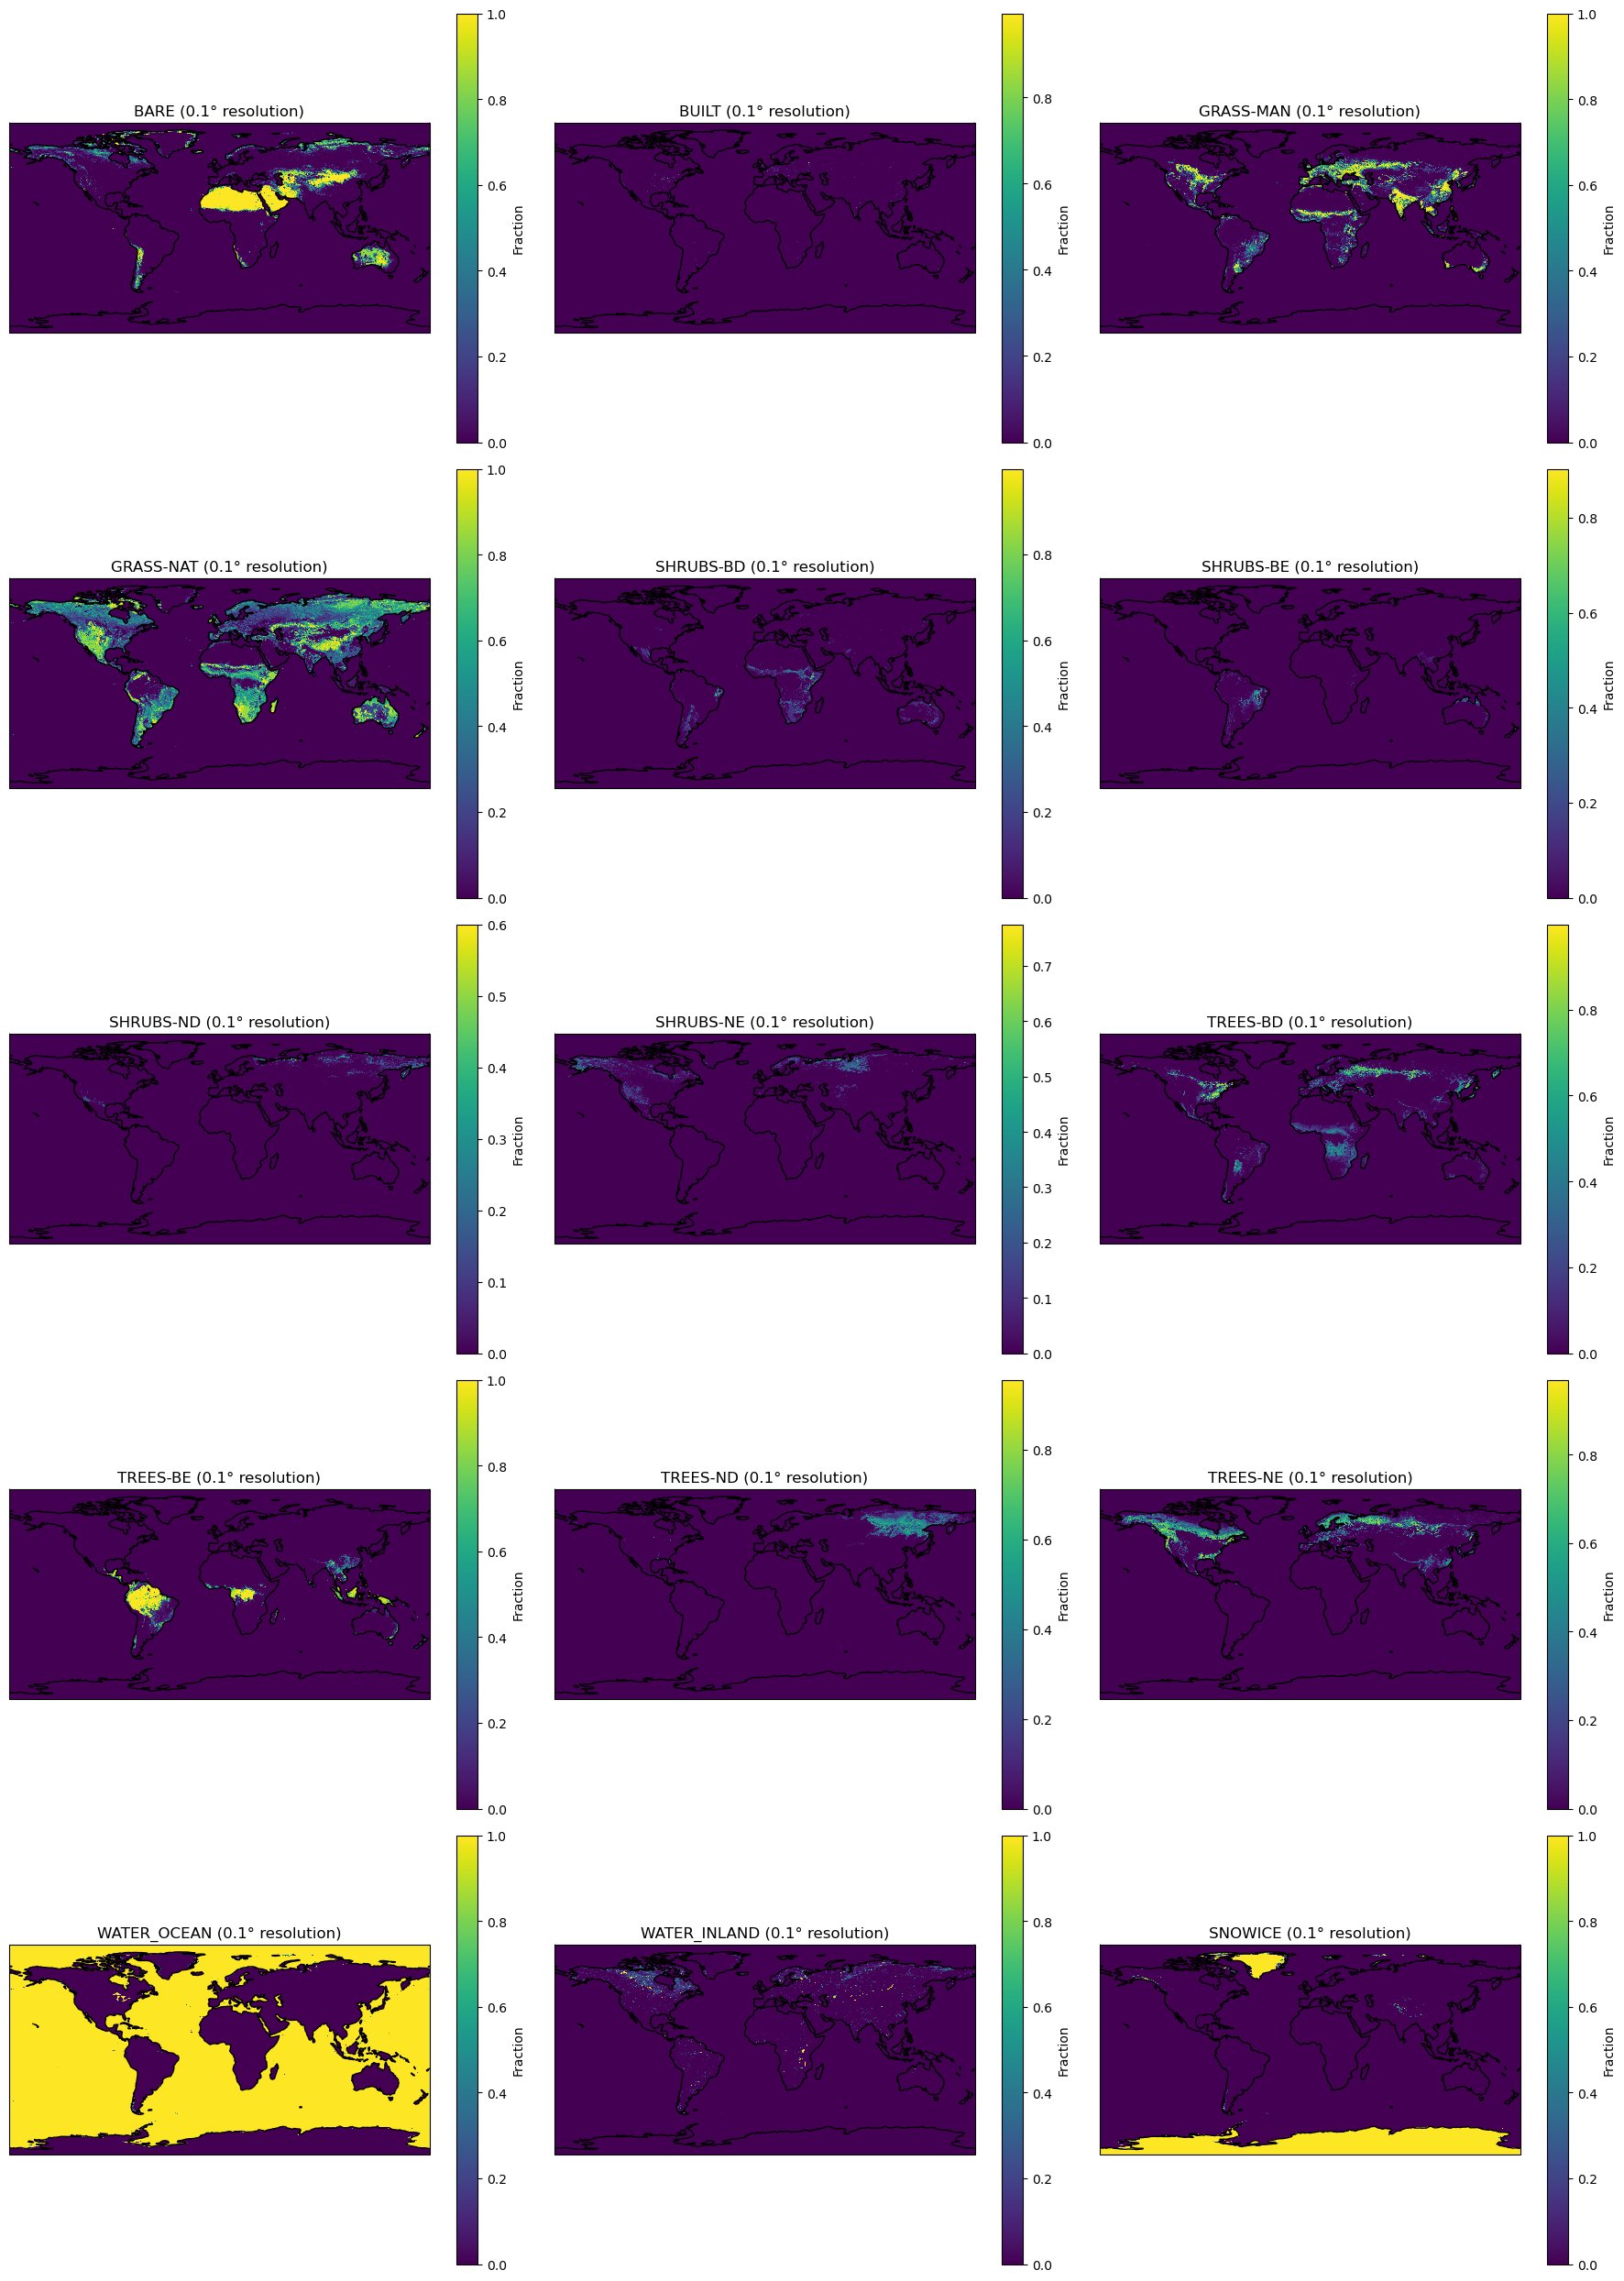

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

PFT_VARS = [
    "BARE","BUILT",
    "GRASS-MAN","GRASS-NAT",
    "SHRUBS-BD","SHRUBS-BE","SHRUBS-ND","SHRUBS-NE",
    "TREES-BD","TREES-BE","TREES-ND","TREES-NE",
    "WATER_OCEAN","WATER_INLAND","SNOWICE"
]

# Create subplots for each variable (5 rows, 3 columns for 15 variables)
fig, axes = plt.subplots(5, 3, figsize=(18, 25), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for i, var in enumerate(PFT_VARS):
    ax = axes_flat[i]
    pft_on_clim[var].isel(year=0).plot(
        ax=ax, 
        cmap='viridis',
        cbar_kwargs={'label': 'Fraction'}
    )
    ax.coastlines()
    ax.set_title(f'{var} (0.1° resolution)')

plt.tight_layout()
plt.show()